# El modelo de la telaraña

## Objetivo

En este cuaderno se presenta el modelo de la telaraña para dos mercados, con el fin de ilustrar los siguientes conceptos
* Sesgo de simultaneidad
* Estimación de mínimos cuadrados en dos etapas
* Efectos dinámicos de una perturbación

En particular, si $q$ y $p$ denotan cantidad y precio,$s$ y $d$ representan oferta y demanda, $m$ y $w$ maíz y trigo, y $t$ tiempo, el modelo es

\begin{align*} 
q^s_{mt} &= 0.5p_{m,t-1} - 0.2p_{w,t-1} + 200 + \epsilon^s_{mt}  \tag{oferta de maíz}\\
q^s_{wt} &= -0.2p_{m,t-1} + 0.4p_{w,t-1} + 80 + \epsilon^s_{wt}  \tag{oferta de trigo} \\
q^d_{mt} &= - 0.2p_{mt} + 1.2p_{wt} + 100 + \epsilon^d_{mt} \tag{demanda de maíz}\\
q^d_{wt} &= 1.1p_{mt} - 0.4p_{wt} + 50 + \epsilon^d_{wt} \tag{demanda de trigo}
\end{align*}

y puede escribirse
\begin{equation*}
\underset{\Gamma}{\begin{pmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 1 & 0 & 0.2 & -1.2 \\ 0 & 1 & -1.1 & 0.4\end{pmatrix}} 
\underset{Y_t}{\begin{pmatrix}q_{mt} \\ q_{wt} \\ p_{mt} \\ p_{wt}\end{pmatrix}} = 
\underset{B}{\begin{pmatrix}0.5 & -0.2 \\ -0.2 & 0.4 \\  0 & 0 \\ 0 & 0\end{pmatrix}} 
\underset{Y_{t-1}}{\begin{pmatrix}p_{m,t-1} \\ p_{w,t-1}\end{pmatrix}}  +
\underset{c}{\begin{pmatrix}200 \\ 80 \\ 100 \\50\end{pmatrix}} +
\underset{\epsilon_t}{\begin{pmatrix}\epsilon^s_{mt} \\ \epsilon^s_{wt} \\ \epsilon^d_{mt} \\ \epsilon^d_{wt}\end{pmatrix}}
\end{equation*}

## Preparación

Importamos los paquetes de Python necesarios. En particular
* numpy: para operaciones de álgebra lineal
* pyplot: para graficar
* pandas: para manejar datos en una tabla
* statstmodels: estimaciones econométricas

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.formula.api import ols
from joblib import Parallel, delayed


%matplotlib inline
sns.set(style="white")
np.set_printoptions(precision=3)
figpath = '../figures/'

Definimos los parámetros del modelo

In [4]:
T = 100
endogenas = ['Q_maiz','Q_trigo','P_maiz','P_trigo']

Gamma = np.array([      # RELACIÓN SIMULTANEA
    [1, 0,   0,    0],  # oferta maiz
    [0, 1,   0,    0],  # oferta trigo
    [1, 0, 0.2, -1.2],  # demanda maiz
    [0, 1,-1.1, 0.4]])  # demanda trigo 

cstr = np.array([200,80,100,50])  # interceptos forma estructural

Beta = np.array([  # PENDIENTES ESTRUCTURALES
    [ 0.5, -0.2],  # oferta maiz
    [-0.2,  0.4],  # oferta trigo
    [   0,    0],  # demanda maiz
    [   0,    0]]) # demanda trigo 

A partir de la inversa de $\Gamma$, obtenemos los parámetros de la forma reducida

In [5]:
Gammainv = np.linalg.inv(Gamma)

cred = Gammainv @ cstr # interceptos forma reducida
Pi = Gammainv @ Beta   # pendientes forma reducida 

In [6]:
Pi

array([[ 0.5  , -0.2  ],
       [-0.2  ,  0.4  ],
       [-0.032,  0.323],
       [ 0.411, -0.113]])

## Identificación del sistema
Ahora verificamos que el sistema está exactamente identificado, utilizando las condiciones de rango y de orden.

In [7]:
coeffs = np.c_[Gamma, Beta, cstr]
restr = np.abs(coeffs) == coeffs**2 # coeficientes restringidos son 1, -1 o 0. Esto funciona para este ejemplo en particular
for i, fila in enumerate(restr):
    temp = coeffs[:,fila]
    print(f'\nLa ecuación {i+1} tiene {temp.shape[1]} restricciones y sus eigenvalores son', np.linalg.eigvals(temp))
    


La ecuación 1 tiene 4 restricciones y sus eigenvalores son [-0.853  1.453  1.     1.   ]

La ecuación 2 tiene 4 restricciones y sus eigenvalores son [-0.853  1.453  1.     1.   ]

La ecuación 3 tiene 4 restricciones y sus eigenvalores son [ 1.452  1.203 -0.452 -0.203]

La ecuación 4 tiene 4 restricciones y sus eigenvalores son [ 1.452  1.203 -0.452 -0.203]


## Simulación del modelo

Definimos la función *telaraña*, la cual simula $T$ observaciones de los precios y cantidades de trigo, luego de desechar las primeras *drop* observaciones. El resultado se retorna como una tabla de *Pandas*, la cual facilita la creación de gráficos y la estimación econométrica posterior.

In [22]:
def Monte_Carlo(funcion, repeticiones, *args, **kwargs):
    """
    Ejecuta simulaciones de Montecarlo en paralelo, aprovechando todos los núcleos del procesador

    Argumentos:
        funcion: una función que dé por resultado una única realización de las cantidades que se desean simular
        repeticiones: un entero que indica cuántas muestras se desean simular
        *args, **kwargs: otros parámetros requeridos por funcion

    Retorna:
         Un data frame de pandas, con tantas filas como `repeticiones` y columnas como parámetros se estimen.
    """
    datos = Parallel(n_jobs=-1)(delayed(funcion)(*args, **kwargs) for _ in range(repeticiones))
    return pd.DataFrame(datos)

In [9]:
def telaraña(T, drop=10, estocastico=True):
    if estocastico:
        e_struc = np.random.randn(T+drop,4)
        e_reduc = e_struc @ Gammainv.T
    else:
        e_reduc = np.zeros((T+drop,4))
            
    y = np.zeros((T+drop,4))
    y[0,-2:] = [120, 70]
    for t in range(T+drop-1):
        y[t+1] = cred + Pi @ y[t,-2:] + e_reduc[t+1]
    return pd.DataFrame(y[drop:], columns=endogenas)

Simulamos una muestra de 100 observaciones. 

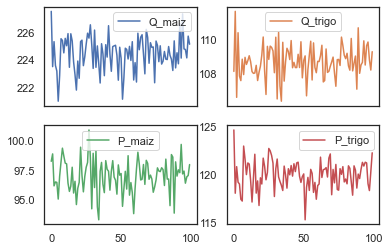

In [10]:
datos = telaraña(100)

ax=datos.plot(subplots=True, layout=[2,2])

Los datos simulados aparentan ser estacionarios. Para confirmarlo, podemos escribir el modelo en forma de un VAR(1) reducido:

\begin{equation*}
\begin{pmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 1 & 0 & 0.2 & -1.2 \\ 0 & 1 & -1.1 & 0.4\end{pmatrix}
\begin{pmatrix}q_{mt} \\ q_{wt} \\ p_{mt} \\ p_{wt}\end{pmatrix} = 
\begin{pmatrix}0 & 0 & 0.5 & -0.2 \\0 & 0 &  -0.2 & 0.4 \\0 & 0 &   0 & 0 \\0 & 0 &  0 & 0\end{pmatrix}
\begin{pmatrix}q_{m,t-1} \\ q_{w,t-1} \\ p_{m,t-1} \\ p_{w,t-1}\end{pmatrix}  +
\begin{pmatrix}200 \\ 80 \\ 100 \\50\end{pmatrix} +
\begin{pmatrix}\epsilon^s_{mt} \\ \epsilon^s_{wt} \\ \epsilon^d_{mt} \\ \epsilon^d_{wt}\end{pmatrix}
\end{equation*}

y obtenemos los eigenvalores de su matriz de coeficientes autorregresivos.




In [11]:
arcoefstr = np.c_[np.zeros([4,2]),Beta]
arcoef = Gammainv @ arcoefstr
print('La matriz de coeficientes autorregresivos en forma reducida es \n', arcoef)
print('\nLos eigenvalores de la matriz autorregresiva en forma reducida son ', np.linalg.eigvals(arcoef) )

La matriz de coeficientes autorregresivos en forma reducida es 
 [[ 0.     0.     0.5   -0.2  ]
 [ 0.     0.    -0.2    0.4  ]
 [ 0.     0.    -0.032  0.323]
 [ 0.     0.     0.411 -0.113]]

Los eigenvalores de la matriz autorregresiva en forma reducida son  [ 0.     0.     0.294 -0.439]


Como todos los eigenvalores están dentro del círculo unitario, hemos confirmado que el sistema es estable y por tanto estacionario. Siendo estacionario, el sistema tiene media constante, que calculamos a continuación:

In [12]:
esperados = np.linalg.inv(np.eye(4) - arcoef) @ cred
for val in zip(endogenas, esperados): print('%10s: %6.2f' % val)

    Q_maiz: 224.44
   Q_trigo: 108.57
    P_maiz:  96.83
   P_trigo: 119.84


Text(0, 0.5, 'Precio del trigo')

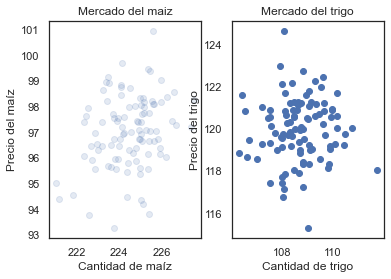

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.scatter(datos['Q_maiz'], datos['P_maiz'], alpha=0.15)
ax.set_title('Mercado del maiz')
ax.set_xlabel('Cantidad de maíz')
ax.set_ylabel('Precio del maíz')

ax = fig.add_subplot(1, 2, 2)
ax.scatter(datos['Q_trigo'], datos['P_trigo'])
ax.set_title('Mercado del trigo')
ax.set_xlabel('Cantidad de trigo')
ax.set_ylabel('Precio del trigo')

Wall time: 14.3 s


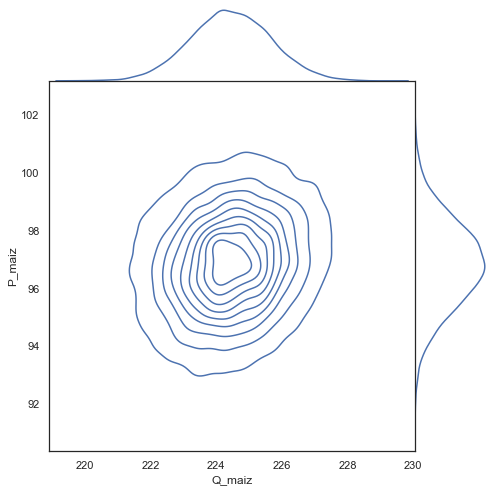

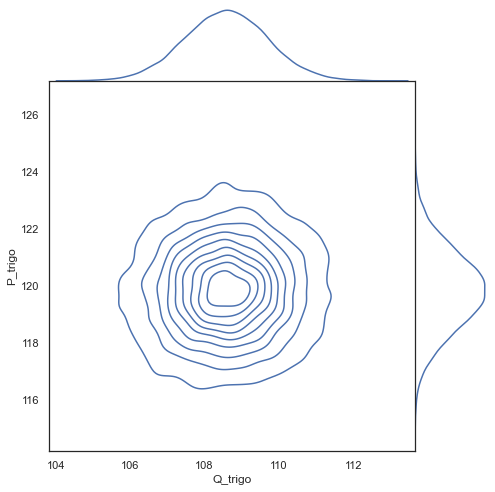

In [15]:
%%time
datos = telaraña(10000)
datos.index = pd.date_range(start='1970',periods=datos.shape[0],freq='D')

g = sns.jointplot(x='Q_maiz',y='P_maiz',data=datos, kind="kde", height=7, space=0)
g = sns.jointplot(x='Q_trigo',y='P_trigo',data=datos, kind="kde", height=7, space=0)

In [16]:
datos['LP_maiz'] = datos['P_maiz'].shift()   # precio maiz rezagado
datos['LP_trigo'] = datos['P_trigo'].shift() # precio trigo rezagado

## Estimación OLS de la forma estructural del modelo

A continuación simulamos el modelo de la telaraña 1000 veces, y estimamos cada ecuación del modelo con OLS. Luego presentamos histogramas para cada uno de los coeficientes estimados, mostrando con una línea vertical roja el verdadero valor poblacional en cada caso

In [17]:
NSIMUL = 1000

def ols_params(modelo, T=24):
    datos = telaraña(T)
    datos['LP_maiz'] = datos['P_maiz'].shift()   # precio maiz rezagado
    datos['LP_trigo'] = datos['P_trigo'].shift() # precio trigo rezagado
    return ols(modelo, datos).fit().params

true_params = {
    'ms': np.r_[cstr[0],Beta[0]],
    'ws': np.r_[cstr[1],Beta[1]],
    'md': np.r_[cstr[2], -Gamma[2,-2:]],
    'wd': np.r_[cstr[3], -Gamma[3,-2:]]}

description = {
    'ms': 'Oferta de maíz',
    'ws': 'Oferta de trigo',
    'md': 'Demanda de maíz',
    'wd': 'Demanda de trigo'}




def plot_result(estimador, modelo, T, truval, drop_outlier=0):
    simul = Monte_Carlo(estimador, NSIMUL, modelo, T)
        
    if drop_outlier:
        regressors = simul.columns
        simul['outlier'] = 0
        for k, regr in enumerate(regressors):
            simul.sort_values(regr, inplace=True)
            simul.iloc[:drop_outlier, k] = np.nan
            simul.iloc[-drop_outlier:, k] = np.nan
            
        simul.dropna(inplace=True)
        del simul['outlier']

    fig, axs = plt.subplots(1,3,figsize=[12,2.5])
    true_values = true_params[truval]
    for ax, serie, xv in zip(axs, simul, true_values):
        simul[serie].hist(bins=20,ax=ax, alpha=0.75)
        ax.axvline(x=xv,linewidth=4, color='r')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set(yticks=[], xlabel=serie)
        ax.grid(False)
    
    axs[0].annotate(description[truval], (-0.1, 0.5), xycoords='axes fraction',
                    size=20, rotation=90, ha='center',va='center', 
                    backgroundcolor='#0064b0', color='white')
    #fig.suptitle(description[truval], size=16)
    print('\n', modelo, true_values,   '\n',simul.mean())
    return fig

### Oferta de maiz y trigo
Las ecuaciones de oferta no tienen sesgo de simultaneidad, porque las cantidades ofrecidas dependen de los precios rezagados, los cuales no están correlacionados con los shocks contemporáneos de oferta.

In [23]:
Monte_Carlo(ols_params, 7, 'Q_maiz ~ 1 + LP_maiz + LP_trigo', 24)

,Intercept,LP_maiz,LP_trigo
0,183.598488,0.739134,-0.257571
1,185.306877,0.262573,0.115573
2,198.337971,0.525838,-0.207585
3,201.394560,0.767370,-0.426789
4,215.070056,0.461896,-0.297432
5,225.496433,0.384742,-0.318540
6,186.046698,0.579381,-0.146089



 Q_maiz ~ 1 + LP_maiz + LP_trigo [200.    0.5  -0.2] 
 Intercept    201.946139
LP_maiz        0.496543
LP_trigo      -0.213399
dtype: float64

 Q_trigo ~ 1 + LP_maiz + LP_trigo [80.  -0.2  0.4] 
 Intercept    82.674495
LP_maiz      -0.209767
LP_trigo      0.385509
dtype: float64
Wall time: 9.4 s


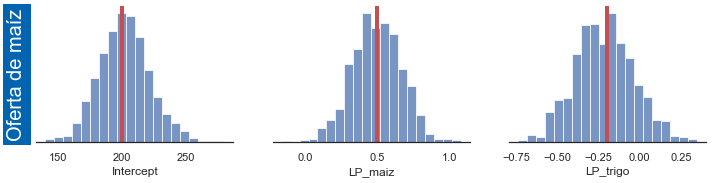

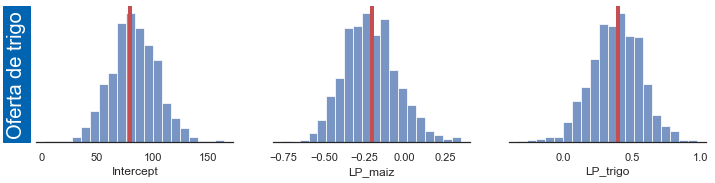

In [24]:
%%time
fig_ms_ols = plot_result(ols_params, 'Q_maiz ~ 1 + LP_maiz + LP_trigo', 24, 'ms')   # oferta de maiz
fig_ws_ols = plot_result(ols_params, 'Q_trigo ~ 1 + LP_maiz + LP_trigo', 24, 'ws')  # oferta de trigo

### Demanda de maiz y trigo
Las ecuaciones de demanda sí tienen sesgo de simultaneidad, porque las cantidades demandadas dependen de los precios contemporáneos, los cuales están correlacionados con los shocks contemporáneos de oferta y de demanda


 Q_maiz ~ 1 + P_maiz + P_trigo [100.   -0.2   1.2] 
 Intercept    153.847493
P_maiz        -0.157689
P_trigo        0.716429
dtype: float64

 Q_trigo ~ 1 + P_maiz + P_trigo [50.   1.1 -0.4] 
 Intercept    80.574229
P_maiz        0.618602
P_trigo      -0.266227
dtype: float64
Wall time: 8.67 s


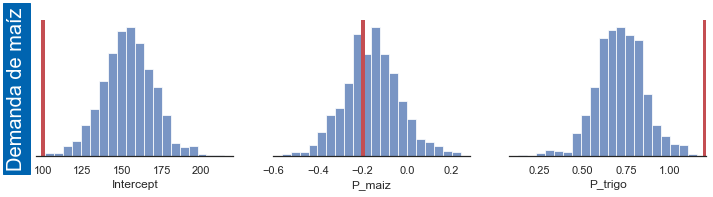

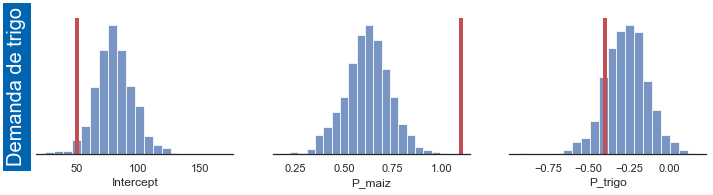

In [25]:
%%time
fig_md_ols = plot_result(ols_params, 'Q_maiz ~ 1 + P_maiz + P_trigo', 24, 'md')  # Demanda de maíz
fig_wd_ols = plot_result(ols_params, 'Q_trigo ~ 1 + P_maiz + P_trigo', 24, 'wd') # Demanda de trigo

## Estimación 2SLS de la forma estructural del modelo

A continuación simulamos el modelo de la telaraña 500 veces, y estimamos cada ecuación del modelo con OLS. Luego presentamos histogramas para cada uno de los coeficientes estimados, mostrando con una línea vertical roja el verdadero valor poblacional en cada caso

In [26]:
def tsls_params(modelo, T=24):
    datos = telaraña(T)
    datos['LP_maiz'] = datos['P_maiz'].shift()   # precio maiz rezagado
    datos['LP_trigo'] = datos['P_trigo'].shift() # precio trigo rezagado
 
    etapa1 = pd.concat([ols('%s ~ LP_maiz + LP_trigo' % x, datos).fit().fittedvalues for x in endogenas],axis=1)
    etapa1.columns = [st + '_OLS' for st in endogenas]
    datos = pd.concat([datos, etapa1], axis=1)
    return ols(modelo, datos).fit().params



 Q_maiz_OLS ~ 1 + P_maiz_OLS + P_trigo_OLS [100.   -0.2   1.2] 
 Intercept      120.086899
P_maiz_OLS      -0.347619
P_trigo_OLS      1.151286
dtype: float64

 Q_trigo_OLS ~ 1 + P_maiz_OLS + P_trigo_OLS [50.   1.1 -0.4] 
 Intercept      53.747977
P_maiz_OLS      1.031463
P_trigo_OLS    -0.375958
dtype: float64
Wall time: 25.7 s


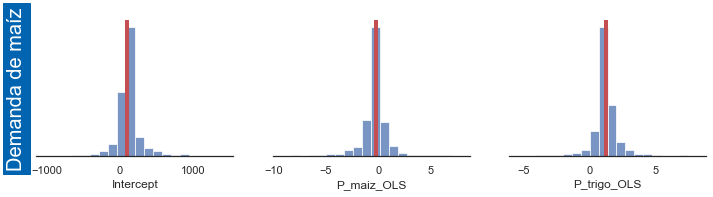

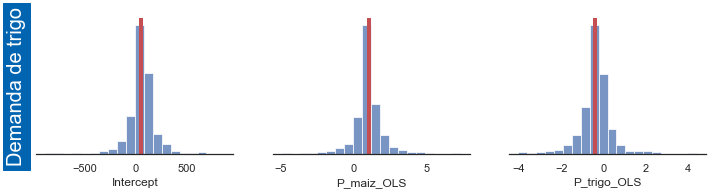

In [27]:
%%time
fig_md_2sls = plot_result(tsls_params, 'Q_maiz_OLS ~ 1 + P_maiz_OLS + P_trigo_OLS', 24, 'md',20)  # Demanda de maíz
fig_wd_2sls = plot_result(tsls_params, 'Q_trigo_OLS ~ 1 + P_maiz_OLS + P_trigo_OLS', 24, 'wd',20) # Demanda de trigo

In [20]:
plt.rc('savefig', bbox='tight')
fig_ws_ols.savefig(figpath+'oferta-trigo-ols.pdf')
fig_ms_ols.savefig(figpath+'oferta-maiz-ols.pdf')
fig_wd_ols.savefig(figpath+'demanda-trigo-ols.pdf')
fig_md_ols.savefig(figpath+'demanda-maiz-ols.pdf')
fig_wd_2sls.savefig(figpath+'demanda-trigo-2sls.pdf')
fig_md_2sls.savefig(figpath+'demanda-maiz-2sls.pdf')
